# Previsione dell'affidabilità creditizia per il rilascio della carta di credito


### *Traccia*
 


Sei stato assunto dalla Pro National Bank come data scientist, il tuo primo incarico consiste nel realizzare un modello in grado di stimare l'affidabilità creditizia dei clienti, al fine di di aiutare il team dedicato a comprendere se accettare o meno la richiesta per il rilascio della carta di credito.

A tal fine ti vengono consegnati i dati anonimizzati di clienti che hanno già ottenuto la carta di credito e lo stato del loro debito mensile. 


In [1]:
# import librerie

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import warnings
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from statistics import mean
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.datasets import make_classification
from sklearn.svm import SVC



In [2]:
# read the data

credit_record = pd.read_csv("credit_record.csv")
application_record = pd.read_csv("application_record.csv")


### Creazione della variabile target

#### MEOTODO 1

* se un cliente ha la prevalenza della classe 'C', ovvero sono più i mesi in cui ha saldato il debito rispetto agli altri gli verrà assegnata la classe 0 (affidabile) altrimenti 1 (non afffidabile)

* * la classe 1 viene assegnata ai clienti non affidabili perchè lo scopo del modello è quello di studiare l affidabilità creditizia dei clienti, di consegunza per una banca è più importante selezionare i clienti non affidabili (con cui si avranno problemi nella riscossione del credito) piuttosto che gli altri.

* per il momento vengono esclusi tutti i clienti che non hanno mai contratto debiti in quanto non forniscono informazioni riguardo la loro affidabilità


In [228]:
def classify_creditor(credit_record):
    """
    Classifies a creditor as good (1) or bad (0) based on their credit history.
    
    Args:
    credit_history (dataframe): A dataframe containing
                           'ID CLIENT', 'MONTHS_BALANCE', 'STATUS'.
                           
    Returns:
    a dataframe containing
                        'ID CLIENT', 'RELIABILITY'
    """
    
    # eliminate customers who have never had debt because they do not provide information regarding reliability

    # Group by ID and check if all values in STATUS are 'X' for each ID
    ids_to_remove = credit_record.groupby('ID').filter(lambda x: (x['STATUS'] == 'X').all())['ID'].unique()

    # delete ID that have always 'X' in STATUS columns
    cleaned_credit_records = credit_record[~credit_record['ID'].isin(ids_to_remove)]

    # for each id it checks whether the value c of the status column prevails
    prevalence_of_c = cleaned_credit_records.groupby('ID')['STATUS'].apply(lambda x: (x == 'C').mean())
    classification = (~ (prevalence_of_c >= 0.5)).astype(int)

    # add a new colums 'Classification' at the dataframe
    cleaned_credit_records['CLASSIFICATION'] = cleaned_credit_records['ID'].map(classification)

    # delete ID duplciate
    cleaned_credit_records = cleaned_credit_records[['ID', 'CLASSIFICATION']].drop_duplicates(subset='ID', keep='first')

    return cleaned_credit_records

    


#### METODO 2

*  clienti che hannno solo X, ovvero non hanno mai riscontrato debiti, vengono eliminati dal dataset.
*  ai clienti con almeno una volta lo status 4 o 5 viene assegnata la classe 1 indipendentemente dalle altre condizioni.
*  ai clienti che mostrano trend negativi nel pagamento di almeno 3 valori di status partendo da 0 (esempio mese -2, 0 mese -1, 1 mese 0, 2     opppure mese -2, 1 mese -1, 2 mese 0, 3) viene assegnata la classe 1.
*  ai clienti con valori della classe C inferiori al 30% viene assegnata la classe 1.
*  a tutti gli altri clienti viene assegnata la classe 0.


In [229]:
def classify_creditor_2(credit_record):
    """
    Classifies a creditor as good (0) or bad (1) based on their credit history.
    
    Args:
    credit_record (dataframe): A dataframe containing
                           'ID', 'MONTHS_BALANCE', 'STATUS'.
                           
    Returns:
    a dataframe containing
                        'ID', 'RELIABILITY'
    """
    
    # Step 1: Remove customers who have only 'X' in their STATUS, which means they never had debt.
    credit_record = credit_record[credit_record['STATUS'] != 'X']
    grouped = credit_record.groupby('ID')

    # Step 2: Classify as bad (1) if any STATUS is '4' or '5'.
    has_bad_status = grouped['STATUS'].apply(lambda x: any(x.isin(['4', '5']))).astype(int)

    # Step 3: Identify negative payment trends.
    def has_negative_trend(group):
        status_values = group['STATUS'].replace({'C': -1, 'X': -1}).astype(int)
        return (status_values.diff().fillna(0) > 0).sum() >= 3

    negative_trend = grouped.apply(has_negative_trend).astype(int)
    
    # Step 4: Check if 'C' values are less than 30% for each ID.
    less_than_30pc_C = grouped['STATUS'].apply(lambda x: (x == 'C').mean() < 0.3).astype(int)

    # Combine the conditions
    classification = (has_bad_status | negative_trend | less_than_30pc_C)

    # Step 5: Classify all others as good (0).
    # Note: By default, any ID not classified as bad (1) is already considered good (0).
    
    # Construct the final dataframe with ID and RELIABILITY.
    final_df = classification.reset_index(name='CLASSIFICATION')
    
    return final_df



### !!!!!!! Attenzione !!!!!!!

Selezionare togliendo il commento il modo in cui si desidera classificare i clienti

In [230]:
credit_records_1 = classify_creditor(credit_record)
#credit_records_1 = classify_creditor_2(credit_record)

#### Aggiunta della colonna TARGET al dataframe application_recors


In [231]:
warnings.filterwarnings('ignore')

credit_records_1.set_index('ID', inplace=True)

application_record['TARGET'] = application_record[application_record['ID'].isin(credit_records_1.index)]['ID'].map(credit_records_1['CLASSIFICATION'].to_dict())
application_record = application_record.dropna(subset=['TARGET'])



### Pulizia del dataset

* elimino le colonne con dati mancanti almeno pari al 25%

In [232]:
for i in application_record.columns:
    
    to_delete = application_record[i].isna().sum()/len(application_record) >= 0.25
    
    if to_delete:
        application_record = application_record.drop(i, axis='columns') 


* elimino le righe con dati mancanti almeno pari al 25%

In [233]:
row_na = application_record.isna().sum(axis=1)
row_na = row_na[row_na >= application_record.shape[1]*0.25] 
row_na

# there aren't row to delete

"""
to_remove = row_na.index.values
application_record = application_record.drop(to_remove)
application_record.shape
"""


'\nto_remove = row_na.index.values\napplication_record = application_record.drop(to_remove)\napplication_record.shape\n'

* Imputazione dei dati mancanti

In [234]:
columns_with_missing_data = application_record.count() - application_record.shape[0]
columns_with_missing_data

# there aren't columns with missing data

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
CNT_FAM_MEMBERS        0
TARGET                 0
dtype: int64

* Studio le relazioni tra le features e la variabile di risposta

Per verificare la correlazione tra features e varibile TARGET si userà:

1. il metodo di Cramer: quando la variabile di risposta è confrontata con una variabile categorica.

2. il metodo Punto-Biseriale: quando la variabile di risposta è confrontata con una variabile continua o discreta.


In [235]:
# cramer

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [236]:
coeff_cramer_CODE_GENDER = cramers_v(application_record['TARGET'], application_record["CODE_GENDER"])
coeff_cramer_FLAG_OWN_CAR = cramers_v(application_record['TARGET'], application_record["FLAG_OWN_CAR"])
coeff_cramer_FLAG_OWN_REALTY = cramers_v(application_record['TARGET'], application_record["FLAG_OWN_REALTY"])
coeff_cramer_CNT_CHILDREN = cramers_v(application_record['TARGET'], application_record["CNT_CHILDREN"])
coeff_cramer_NAME_INCOME_TYPE = cramers_v(application_record['TARGET'], application_record["NAME_INCOME_TYPE"])
coeff_cramer_NAME_EDUCATION_TYPE = cramers_v(application_record['TARGET'], application_record["NAME_EDUCATION_TYPE"])
coeff_cramer_NAME_FAMILY_STATUS = cramers_v(application_record['TARGET'], application_record["NAME_FAMILY_STATUS"])
coeff_cramer_NAME_NAME_HOUSING_TYPE = cramers_v(application_record['TARGET'], application_record["NAME_HOUSING_TYPE"])
coeff_cramer_NAME_FLAG_MOBIL = cramers_v(application_record['TARGET'], application_record["FLAG_MOBIL"])
coeff_cramer_NAME_FLAG_WORK_PHONE = cramers_v(application_record['TARGET'], application_record["FLAG_WORK_PHONE"])
coeff_cramer_NAME_FLAG_PHONE = cramers_v(application_record['TARGET'], application_record["FLAG_PHONE"])
coeff_cramer_FLAG_EMAIL = cramers_v(application_record['TARGET'], application_record["FLAG_EMAIL"])


print(f"Correlazione tra TARGET e CODE_GENDER: {coeff_cramer_CODE_GENDER}")
print(f"Correlazione tra TARGET e FLAG_OWN_CAR: {coeff_cramer_FLAG_OWN_CAR}")
print(f"Correlazione tra TARGET e FLAG_OWN_REALTY: {coeff_cramer_FLAG_OWN_REALTY}")
print(f"Correlazione tra TARGET e CNT_CHILDREN: {coeff_cramer_CNT_CHILDREN}")
print(f"Correlazione tra TARGET e NAME_INCOME_TYPE: {coeff_cramer_NAME_INCOME_TYPE}")
print(f"Correlazione tra TARGET e NAME_EDUCATION_TYPE: {coeff_cramer_NAME_EDUCATION_TYPE}")
print(f"Correlazione tra TARGET e NAME_FAMILY_STATUS: {coeff_cramer_NAME_FAMILY_STATUS}")
print(f"Correlazione tra TARGET e NAME_NAME_HOUSING_TYPE: {coeff_cramer_NAME_NAME_HOUSING_TYPE}")
print(f"Correlazione tra TARGET e NAME_FLAG_MOBIL: {coeff_cramer_NAME_FLAG_MOBIL}")
print(f"Correlazione tra TARGET e NAME_FLAG_WORK_PHONE: {coeff_cramer_NAME_FLAG_WORK_PHONE}")
print(f"Correlazione tra TARGET e NAME_FLAG_PHONE: {coeff_cramer_NAME_FLAG_PHONE}")
print(f"Correlazione tra TARGET e FLAG_EMAIL: {coeff_cramer_FLAG_EMAIL}")



Correlazione tra TARGET e CODE_GENDER: 0.0
Correlazione tra TARGET e FLAG_OWN_CAR: 0.0
Correlazione tra TARGET e FLAG_OWN_REALTY: 0.008477525314573945
Correlazione tra TARGET e CNT_CHILDREN: 0.007379848345701687
Correlazione tra TARGET e NAME_INCOME_TYPE: 0.007713993090294961
Correlazione tra TARGET e NAME_EDUCATION_TYPE: 0.026379723499971
Correlazione tra TARGET e NAME_FAMILY_STATUS: 0.009951927103532718
Correlazione tra TARGET e NAME_NAME_HOUSING_TYPE: 0.0138182731040559
Correlazione tra TARGET e NAME_FLAG_MOBIL: nan
Correlazione tra TARGET e NAME_FLAG_WORK_PHONE: 0.00806174606793808
Correlazione tra TARGET e NAME_FLAG_PHONE: 0.00816117145088411
Correlazione tra TARGET e FLAG_EMAIL: 0.0


In [237]:
# punto biseriale

corr_biseriale_AMT_INCOME_TOTAL, p_value_AMT_INCOME_TOTAL = pointbiserialr(application_record['TARGET'], application_record["AMT_INCOME_TOTAL"])
corr_biseriale_DAYS_BIRTH, p_value_DAYS_BIRTH = pointbiserialr(application_record['TARGET'], application_record["DAYS_BIRTH"])
corr_biseriale_DAYS_EMPLOYED, p_value_DAYS_EMPLOYED = pointbiserialr(application_record['TARGET'], application_record["DAYS_EMPLOYED"])
corr_biseriale_CNT_FAM_MEMBERS, p_value_CNT_FAM_MEMBERS = pointbiserialr(application_record['TARGET'], application_record["CNT_FAM_MEMBERS"])


print(f"Correlazione tra TARGET e AMT_INCOME_TOTAL: {corr_biseriale_AMT_INCOME_TOTAL}")
print(f"Correlazione tra TARGET e DAYS_BIRTH: {corr_biseriale_DAYS_BIRTH}")
print(f"Correlazione tra TARGET e DAYS_EMPLOYED: {corr_biseriale_DAYS_EMPLOYED}")
print(f"Correlazione tra TARGET e CNT_FAM_MEMBERS: {corr_biseriale_CNT_FAM_MEMBERS}")


Correlazione tra TARGET e AMT_INCOME_TOTAL: 0.021874219343026066
Correlazione tra TARGET e DAYS_BIRTH: -0.007197487605228776
Correlazione tra TARGET e DAYS_EMPLOYED: 0.00781448150899685
Correlazione tra TARGET e CNT_FAM_MEMBERS: -0.010495479594574714


Le correlazioni riportate con i due metodi sembrano non essere significative, alcune sono perfino esattamente pari a zero.
Si procede inizialmente tenendo tutte le varibili e infine si elimineranno quelle pari a zero confrontando poi il risultato

* Label Encoding

In [238]:
application_record['CODE_GENDER'] = application_record['CODE_GENDER'].map({"M" : 1, "F" : 0})
application_record['FLAG_OWN_CAR'] = application_record['FLAG_OWN_CAR'].map({"Y" : 1, "N" : 0})
application_record['FLAG_OWN_REALTY'] = application_record['FLAG_OWN_REALTY'].map({"Y" : 1, "N" : 0})

# one hot encoding
application_record= pd.get_dummies(application_record, columns=['NAME_INCOME_TYPE'])
application_record = pd.get_dummies(application_record, columns=['NAME_FAMILY_STATUS'])
application_record = pd.get_dummies(application_record, columns=['NAME_HOUSING_TYPE'])

# ordinal encoding
application_record['NAME_EDUCATION_TYPE'] = application_record['NAME_EDUCATION_TYPE'].map({"Academic degree" : 1, "Lower secondary" : 2, "Incomplete higher" : 3, "Higher education" : 4, "Secondary / secondary special" : 5})

# move the target column in the last position
target = application_record['TARGET']
application_record = application_record.drop("TARGET", axis=1)
application_record['TARGET'] = target

application_record.astype(int)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,...,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,TARGET
0,5008804,1,1,1,0,427500,4,-12005,-4542,1,...,0,0,0,0,0,0,0,1,0,0
1,5008805,1,1,1,0,427500,4,-12005,-4542,1,...,0,0,0,0,0,0,0,1,0,0
2,5008806,1,1,1,0,112500,5,-21474,-1134,1,...,0,0,0,0,1,0,0,0,0,1
3,5008808,0,0,1,0,270000,5,-19110,-3051,1,...,0,1,0,0,1,0,0,0,0,1
5,5008810,0,0,1,0,270000,5,-19110,-3051,1,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434808,5149828,1,1,1,0,315000,5,-17348,-2420,1,...,0,0,0,0,1,0,0,0,0,1
434809,5149834,0,0,1,0,157500,4,-12387,-1325,1,...,0,0,0,0,1,0,0,0,0,1
434810,5149838,0,0,1,0,157500,4,-12387,-1325,1,...,0,0,0,0,1,0,0,0,0,1
434811,5150049,0,0,1,0,283500,5,-17958,-655,1,...,0,0,0,0,1,0,0,0,0,1


* Verifico se ci sono squilibri nelle classi

In [239]:
application_record['TARGET'].value_counts()/len(application_record)

TARGET
1.0    0.61199
0.0    0.38801
Name: count, dtype: float64

Le classi sono leggermente ma non eccessivamente sbilanciate, quindi inizialmente si possono evitare di utilizzare tecniche di bilanciamento

## Modellazione

### Regressione Logistica

In [240]:
df_validazione = application_record[0:int(len(application_record)*0.5)].drop("ID", axis=1).copy()
df_test = application_record[int(len(application_record)*0.5) +1: len(application_record)].drop("ID", axis=1).copy()


In [241]:

def classification_report(y_true, y_pred):
  
  return (accuracy_score(y_true, y_pred), precision_score(y_true, y_pred, zero_division='warn'), recall_score(y_true, y_pred) ) 


def get_coeff_logistic_regression(model, df):

  coefficients = model.coef_[0]

  feature_names = df.drop(columns="TARGET", axis=1).columns

  feature_importance = pd.DataFrame(data=coefficients, index=feature_names, columns=['Coefficient'])

  feature_importance['Absolute_Coefficient'] = feature_importance['Coefficient'].abs()

  feature_importance = feature_importance.T

  absolute_coefficients = feature_importance.loc[['Absolute_Coefficient'], :]

  absolute_coefficients = absolute_coefficients.rename(index={ 'Absolute_Coefficient': None })

  return absolute_coefficients


def logistic_regression(random_seed=0, df_validazione=pd.DataFrame(), n_split=10, balance={0: 1, 1: 1}):
  
    RANDOM_SEED = random_seed

    X = df_validazione.drop("TARGET", axis=1).values
    y= df_validazione["TARGET"].values

    kf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_SEED)

    train_score_accuracy_score = []
    train_score_recall_score = []
    train_score_precision_score = []

    test_score_accuracy_score = []
    test_score_recall_score = []
    test_score_precision_score = []

    feature_names = df_validazione.drop(columns="TARGET", axis=1).columns
    coeff_regression = pd.DataFrame(columns=feature_names)


    for train_index, test_index in kf.split(X):
    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        ss = MinMaxScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)

        lr = LogisticRegression(class_weight=balance)
        lr.fit(X_train, y_train)

        coeff_regression = pd.concat([coeff_regression, get_coeff_logistic_regression(lr, df_validazione)], axis=0, ignore_index=True)

        y_train_predict = lr.predict(X_train)
        y_test_predict = lr.predict(X_test)

        train_score_accuracy_score.append(classification_report(y_train, y_train_predict)[0])
        train_score_precision_score.append(classification_report(y_train, y_train_predict)[1])
        train_score_recall_score.append(classification_report(y_train, y_train_predict)[2])

        test_score_accuracy_score.append(classification_report(y_test, y_test_predict)[0])
        test_score_precision_score.append(classification_report(y_test, y_test_predict)[1])
        test_score_recall_score.append(classification_report(y_test, y_test_predict)[2])


    print(f"Accuratezza media fase training: {mean(train_score_accuracy_score)}")
    print(f"Precisione media fase training: {mean(train_score_precision_score)}")
    print(f"Recall medio fase training: {mean(train_score_recall_score)}")

    print(f"Accuratezza media fase test: {mean(test_score_accuracy_score)}")
    print(f"Precisione media fase test: {mean(test_score_precision_score)}")
    print(f"Recall medio fase test: {mean(test_score_recall_score)}")

    print(f"Media del valore assoluto dei coefficienti di regressione: \n {coeff_regression.mean().sort_values(ascending=False)}")



In [242]:
logistic_regression(df_validazione=df_validazione, balance={0: 1, 1: 1})

Accuratezza media fase training: 0.6135843394741596
Precisione media fase training: 0.6139473309234988
Recall medio fase training: 0.9970897719750769
Accuratezza media fase test: 0.6126844797641461
Precisione media fase test: 0.6135134372827561
Recall medio fase test: 0.9962621845346432
Media del valore assoluto dei coefficienti di regressione: 
 NAME_HOUSING_TYPE_Co-op apartment          0.688663
NAME_EDUCATION_TYPE                        0.614881
AMT_INCOME_TOTAL                           0.553145
NAME_INCOME_TYPE_Student                   0.340845
NAME_HOUSING_TYPE_Rented apartment         0.288172
NAME_HOUSING_TYPE_With parents             0.233874
NAME_HOUSING_TYPE_Office apartment         0.214813
CNT_CHILDREN                               0.162961
CNT_FAM_MEMBERS                            0.158744
NAME_HOUSING_TYPE_House / apartment        0.119534
DAYS_EMPLOYED                              0.110891
FLAG_EMAIL                                 0.095203
NAME_INCOME_TYPE_Commercial

### Albero Decisionale

In [243]:

def Decision_Tree(random_seed=0, df_validazione=pd.DataFrame()):

    
    RANDOM_SEED = 0

    X = df_validazione.drop("TARGET", axis=1).values
    y = df_validazione["TARGET"].values

    kf = KFold(n_splits=30, shuffle=True, random_state=RANDOM_SEED)

    train_score_accuracy = []
    train_score_recall = []
    train_score_precision = []

    test_score_accuracy = []
    test_score_recall = []
    test_score_precision = []

    iterator = 0

    for deep in range(2,6,1):   

        for train_index, test_index in kf.split(X):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            ss = MinMaxScaler()
            X_train = ss.fit_transform(X_train)
            X_test = ss.transform(X_test)

            # numero minimo di osservazioni per foglia "min_samples_split" 5% dell insieme di training
            # altezza massima dell'albero uguale a 3 per evitare overfitting
            dt = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED, max_depth=deep, min_samples_split=0.05)
            dt.fit(X_train, y_train)

            y_train_pred = dt.predict(X_train)
            y_test_pred = dt.predict(X_test)

            train_score_accuracy.append(accuracy_score(y_train, y_train_pred))
            train_score_recall.append(recall_score(y_train, y_train_pred))
            train_score_precision.append(precision_score(y_train, y_train_pred))

            test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
            test_score_recall.append(recall_score(y_test, y_test_pred))
            test_score_precision.append(precision_score(y_test, y_test_pred))

        iterator +=1 

        print(f"\n\n interazione: {iterator}  --  altezza: {deep}  --  \n\n")

        print(f"Accuratezza media fase training: {mean(train_score_accuracy)}")
        print(f"Precisione media fase training: {mean(train_score_precision)}")
        print(f"Recall medio fase training: {mean(train_score_recall)}")

        print(f"Accuratezza media fase test: {mean(test_score_accuracy)}")
        print(f"Precisione media fase test: {mean(test_score_precision)}")
        print(f"Recall medio fase test: {mean(test_score_recall)}")

In [244]:
Decision_Tree(df_validazione=df_validazione)



 interazione: 1  --  altezza: 2  --  


Accuratezza media fase training: 0.6141305336354157
Precisione media fase training: 0.6139178567344824
Recall medio fase training: 0.9997012212648465
Accuratezza media fase test: 0.6135289811234733
Precisione media fase test: 0.6136107254142465
Recall medio fase test: 0.9992044093505276


 interazione: 2  --  altezza: 3  --  


Accuratezza media fase training: 0.6148043593129088
Precisione media fase training: 0.6145327889902157
Recall medio fase training: 0.9982853723404376
Accuratezza media fase test: 0.6141632034859763
Precisione media fase test: 0.6141792718436656
Recall medio fase test: 0.9978622952126806


 interazione: 3  --  altezza: 4  --  


Accuratezza media fase training: 0.6150331337576362
Precisione media fase training: 0.6147403384326505
Recall medio fase training: 0.9978134226989679
Accuratezza media fase test: 0.614374610940144
Precisione media fase test: 0.6143687873201387
Recall medio fase test: 0.9974149238333981


 interazi

* Mostro l'albero ottenuto sul 75% dei dati di training

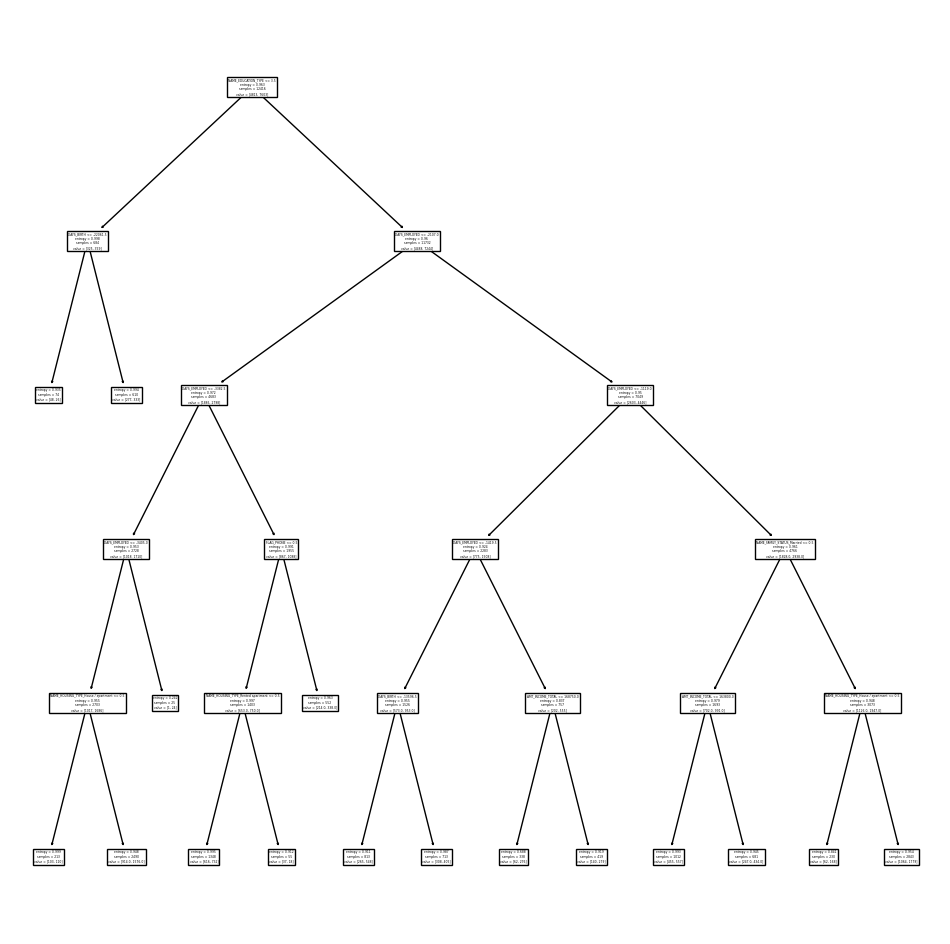

In [245]:
X = df_validazione.drop("TARGET", axis=1).values
y = df_validazione["TARGET"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

tree = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=5, min_samples_split=0.05)
tree.fit(X_train, y_train)

plt.figure(figsize=(12,12))
plot_tree(tree, feature_names=df_validazione.columns)
plt.show()

### Naive Bayes

In [246]:
def Naive_Bayes(type, n_split=10, random_seed=0, df_validazione=pd.DataFrame()):

    
    RANDOM_SEED = random_seed

    X = df_validazione.drop("TARGET", axis=1).values
    y= df_validazione["TARGET"].values

    kf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_SEED)

    train_score_accuracy_score = []
    train_score_recall_score = []
    train_score_precision_score = []

    test_score_accuracy_score = []
    test_score_recall_score = []
    test_score_precision_score = []


    for train_index, test_index in kf.split(X):
    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        ss = MinMaxScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)

        if type == "GAUSSIAN":
            nb = GaussianNB()
        
        elif type == "MULTINOMINAL":
            nb = MultinomialNB()

        elif type == "BERNOULLI":
            nb = BernoulliNB()

        else:
            return
        
        nb.fit(X_train, y_train)

        y_train_predict = nb.predict(X_train)
        y_test_predict = nb.predict(X_test)

        train_score_accuracy_score.append(classification_report(y_train, y_train_predict)[0])
        train_score_precision_score.append(classification_report(y_train, y_train_predict)[1])
        train_score_recall_score.append(classification_report(y_train, y_train_predict)[2])

        test_score_accuracy_score.append(classification_report(y_test, y_test_predict)[0])
        test_score_precision_score.append(classification_report(y_test, y_test_predict)[1])
        test_score_recall_score.append(classification_report(y_test, y_test_predict)[2])


    print(f"Accuratezza media fase training: {mean(train_score_accuracy_score)}")
    print(f"Precisione media fase training: {mean(train_score_precision_score)}")
    print(f"Recall medio fase training: {mean(train_score_recall_score)}")

    print(f"Accuratezza media fase test: {mean(test_score_accuracy_score)}")
    print(f"Precisione media fase test: {mean(test_score_precision_score)}")
    print(f"Recall medio fase test: {mean(test_score_recall_score)}")



* #### Gaussian Naive Bayes

In [247]:
Naive_Bayes(type="GAUSSIAN", n_split=20, df_validazione=df_validazione[["AMT_INCOME_TOTAL", "TARGET"]])

Accuratezza media fase training: 0.6134702541766656
Precisione media fase training: 0.6134702541766656
Recall medio fase training: 1.0
Accuratezza media fase test: 0.6134715139407322
Precisione media fase test: 0.6134715139407322
Recall medio fase test: 1.0


* #### Bernoulli Naive Bayes

In [248]:
df_validazione_naive_bernoulli = df_validazione[["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "FLAG_MOBIL", "FLAG_WORK_PHONE", "FLAG_PHONE", "FLAG_EMAIL", "TARGET"]]
Naive_Bayes(type="BERNOULLI", n_split=20, df_validazione=df_validazione_naive_bernoulli)

Accuratezza media fase training: 0.6134702541766656
Precisione media fase training: 0.6134702541766656
Recall medio fase training: 1.0
Accuratezza media fase test: 0.6134715139407322
Precisione media fase test: 0.6134715139407322
Recall medio fase test: 1.0


* #### Multinomial Naive Bayes


In [249]:
df_validazione_naive_multinominal = df_validazione.drop(["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "AMT_INCOME_TOTAL", "DAYS_BIRTH", "DAYS_EMPLOYED", "FLAG_MOBIL", "FLAG_WORK_PHONE", "FLAG_PHONE", "FLAG_EMAIL"], axis=1)
Naive_Bayes(type="BERNOULLI", n_split=20, df_validazione=df_validazione_naive_multinominal)

Accuratezza media fase training: 0.6140202550224161
Precisione media fase training: 0.6139579130357661
Recall medio fase training: 0.9989272507960454
Accuratezza media fase test: 0.614015284276443
Precisione media fase test: 0.613953985503651
Recall medio fase test: 0.9989137438921933


* #### Multinomial Naive Bayes con le features che hanno mostrato maggiore correlazione con la variabile target

 * * Verifico se le features sono indpipendenti

In [250]:
application_record_2 = pd.read_csv("application_record.csv")
cramers_v(application_record_2["NAME_HOUSING_TYPE"], application_record_2["NAME_EDUCATION_TYPE"])

0.040793864256316086

In [251]:
df_validazione_naive_multinominal = df_validazione[['NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HOUSING_TYPE_House / apartment', 'NAME_HOUSING_TYPE_Municipal apartment', 'NAME_HOUSING_TYPE_Office apartment', 'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents', 'TARGET']]
Naive_Bayes(type="BERNOULLI", n_split=20, df_validazione=df_validazione_naive_multinominal)

Accuratezza media fase training: 0.6138326821431365
Precisione media fase training: 0.6137889216743759
Recall medio fase training: 0.9993107331819591
Accuratezza media fase test: 0.6138338327813119
Precisione media fase test: 0.6137849915551994
Recall medio fase test: 0.9993035491541906


### Support Vector Machine


In [252]:
def SupportVectorMachine(type, n_split=10, random_seed=0, df_validazione=pd.DataFrame()):

    
    RANDOM_SEED = random_seed

    X = df_validazione.drop("TARGET", axis=1).values
    y= df_validazione["TARGET"].values

    kf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_SEED)

    train_score_accuracy_score = []
    train_score_recall_score = []
    train_score_precision_score = []

    test_score_accuracy_score = []
    test_score_recall_score = []
    test_score_precision_score = []


    for train_index, test_index in kf.split(X):
    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        ss = MinMaxScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)


        if type == "LINEAR":
            svc = SVC(kernel="linear", probability=True)
        
        elif type == "POLYNOMIAL":
            svc = SVC(kernel="poly", probability=True)

        elif type == "GAUSSIAN":
            svc = SVC(kernel="rbf", probability=True)
        
        elif type == "SIGMOIDAL":
            svc = SVC(kernel="sigmoid", probability=True)

        else:
            return
        
        svc.fit(X_train, y_train)

        y_train_predict = svc.predict(X_train)
        y_test_predict = svc.predict(X_test)

        train_score_accuracy_score.append(classification_report(y_train, y_train_predict)[0])
        train_score_precision_score.append(classification_report(y_train, y_train_predict)[1])
        train_score_recall_score.append(classification_report(y_train, y_train_predict)[2])

        test_score_accuracy_score.append(classification_report(y_test, y_test_predict)[0])
        test_score_precision_score.append(classification_report(y_test, y_test_predict)[1])
        test_score_recall_score.append(classification_report(y_test, y_test_predict)[2])


    print(f"Accuratezza media fase training: {mean(train_score_accuracy_score)}")
    print(f"Precisione media fase training: {mean(train_score_precision_score)}")
    print(f"Recall medio fase training: {mean(train_score_recall_score)}")

    print(f"Accuratezza media fase test: {mean(test_score_accuracy_score)}")
    print(f"Precisione media fase test: {mean(test_score_precision_score)}")
    print(f"Recall medio fase test: {mean(test_score_recall_score)}")



* #### Linear Support Vector Machine

In [253]:
# SupportVectorMachine(type="LINEAR", n_split=10, df_validazione=df_validazione)


* #### Polynomial Support Vector Machine

In [254]:
# SupportVectorMachine(type="POLYNOMIAL", n_split=10, df_validazione=df_validazione)


* #### Sigmoidal Support Vector Machine

In [255]:
# SupportVectorMachine(type="SIGMOIDAL", n_split=10, df_validazione=df_validazione)


* #### Gaussian Support Vector Machine

In [256]:
# SupportVectorMachine(type="GAUSSIAN", n_split=20, df_validazione=df_validazione)


# Conclusioni

l'obiettivo di questo progetto è quello di valutare l'affidabilità creditiza dei clienti di una banca.
Sono stati testati diversi modelli e sono stati proposti due diversi metodi di classificazione del cliente in base alle features 'STATUS' e 'MONTH'.
I risultati ottenuti sono simili per entrambi i metodi di classificazione, ovvero si raggiungono alti livelli di recall (> 97%) mentre precisione ed accuratezza non superano mai significativamente il livello percentuale della classe a proporzione più alta, questo suggerisce che tutti i modelli tendano ad assegnare sempre 1 a qualsiasi cliente, ovvero tutti i clienti sono ritenuti inaffidabili.
Questo suggerisce che lefeatures raccolte non sono in grado di spiegare significativamente la variabile target, come infatti si era già riscontrato nella fase preliminare dove si è studiata la correlazione tra features e variabile TARGET.
Variabili che suggeirei invece sono la presenza di altri insoluti con altre banche / compagnie assicurative / qualsiasi istituto finanziario in generale nella storia del cliente e il saldo del conto corrente a fine mese.

* per ultimo viene preso il modello che ha performato meglio e lo si testa sui dati di test, in particolare viene preso il Decision Tree perchè ha dimostrato di essere molto stabile a livello di risultati a tutte le altezze.

In [257]:
Decision_Tree(df_validazione=df_test)



 interazione: 1  --  altezza: 2  --  


Accuratezza media fase training: 0.6104868916110017
Precisione media fase training: 0.6104868916110017
Recall medio fase training: 1.0
Accuratezza media fase test: 0.6104870810208931
Precisione media fase test: 0.6104870810208931
Recall medio fase test: 1.0


 interazione: 2  --  altezza: 3  --  


Accuratezza media fase training: 0.6104868916110017
Precisione media fase training: 0.6104868916110017
Recall medio fase training: 1.0
Accuratezza media fase test: 0.6104870810208931
Precisione media fase test: 0.6104870810208931
Recall medio fase test: 1.0


 interazione: 3  --  altezza: 4  --  


Accuratezza media fase training: 0.6114200971412209
Precisione media fase training: 0.6125437339638075
Recall medio fase training: 0.9899640256050363
Accuratezza media fase test: 0.6101443430331618
Precisione media fase test: 0.6118800416429123
Recall medio fase test: 0.9887439806719229


 interazione: 4  --  altezza: 5  --  


Accuratezza media fase train